In [56]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.utils import plot_model
import numpy as np
import random
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
# Load the dataset
file_path = r"D:\7th Semester\AI\Tamil-SpellGrammar-Checker\data\grammar_checker_dataset\final_dataset.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
df.head()

,Error Sentence,Error Type,Corrected Sentence
0,அவள் பாடல்கள் பாடுகிறான்.,Subject-Verb Agreement,அவள் பாடல்கள் பாடுகிறாள்.
1,நாங்கள் நேரம் பழகுகிறேன்.,Subject-Verb Agreement,நாங்கள் நேரம் பழகுகிறோம்.
2,அவன் புத்தகத்தை படிக்கிறார்கள்.,Subject-Verb Agreement,அவன் புத்தகத்தை படிக்கிறான்.
3,அவர்கள் விளையாட்டு விளையாடுகிறேன்.,Subject-Verb Agreement,அவர்கள் விளையாட்டு விளையாடுகிறார்கள்.
4,நான் வீட்டில் வேலை செய்கிறார்கள்.,Subject-Verb Agreement,நான் வீட்டில் வேலை செய்கிறேன்.


### Data Preprocessing

In [16]:
df = df.dropna(subset=['Error Sentence', 'Corrected Sentence'])

df['Error Sentence'] = df['Error Sentence'].astype(str)
df['Corrected Sentence'] = df['Corrected Sentence'].astype(str)

# Separate the ungrammatical sentences (input) and corrected Sentence sentences (target)
input_sentences = df['Error Sentence'].values
target_sentences = ['<start> ' + sentence + ' <end>' for sentence in df['Corrected Sentence'].values]

In [18]:
input_sentences[0:2]

array(['அவள் பாடல்கள் பாடுகிறான்.', 'நாங்கள் நேரம் பழகுகிறேன்.'],
      dtype=object)

In [19]:
target_sentences[0:2]

['<start> அவள் பாடல்கள் பாடுகிறாள். <end>',
 '<start> நாங்கள் நேரம் பழகுகிறோம். <end>']

### Tokenization

In [21]:
# Tokenize the input sentences 
input_tokenizer = Tokenizer(filters='')
input_tokenizer.fit_on_texts(input_sentences)
input_sequences = input_tokenizer.texts_to_sequences(input_sentences)

# Tokenize the target sentences
output_tokenizer = Tokenizer(filters='')
output_tokenizer.fit_on_texts(target_sentences)
target_sequences = output_tokenizer.texts_to_sequences(target_sentences)

In [22]:
input_sequences[0:2]

[[5, 21, 13], [4, 19, 22]]

In [23]:
target_sequences[0:2]

[[1, 7, 26, 20, 2], [1, 6, 21, 24, 2]]

In [45]:
# Save input tokenizer
with open('input_tokenizer.pkl', 'wb') as f:
    pickle.dump(input_tokenizer, f)

# Save output tokenizer
with open('output_tokenizer.pkl', 'wb') as f:
    pickle.dump(output_tokenizer, f)

In [105]:
output_tokenizer.word_index['<start>'], output_tokenizer.word_index['<end>']

(1, 2)

### Find Maximum Sequence Lengths and Padding

In [24]:
# Find the maximum sequence lengths
max_input_length = max(len(seq) for seq in input_sequences)
max_target_length = max(len(seq) for seq in target_sequences)

# Pad sequences to ensure equal length
encoder_input_data = pad_sequences(input_sequences, maxlen=max_input_length, padding='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=max_target_length, padding='post')

In [25]:
print(f"max_input_length: {max_input_length}")
print(f"max_target_length: {max_target_length}")
print(f"encoder_input_data.shape: {encoder_input_data.shape}")
print(f"decoder_input_data.shape: {decoder_input_data.shape}")

max_input_length: 8
max_target_length: 10
encoder_input_data.shape: (999, 8)
decoder_input_data.shape: (999, 10)


In [96]:
decoder_input_data

array([[ 1,  7, 26, ...,  0,  0,  0],
       [ 1,  6, 21, ...,  0,  0,  0],
       [ 1,  5, 15, ...,  0,  0,  0],
       ...,
       [ 1,  4, 80, ...,  0,  0,  0],
       [ 1,  5, 56, ...,  0,  0,  0],
       [ 1,  3, 19, ...,  0,  0,  0]])

### Prepare Decoder Output Data (One-hot Encoding)

In [26]:
# Prepare decoder output data (shifted by 1 position for teacher forcing)
decoder_output_data = np.zeros((len(target_sequences), max_target_length, len(output_tokenizer.word_index) + 1), dtype='float32')
for i, seq in enumerate(target_sequences):
    for t, word_id in enumerate(seq):
        if t > 0:  # Skip the first token (start token)
            decoder_output_data[i, t - 1, word_id] = 1.0

In [94]:
decoder_output_data.shape

(999, 10, 667)

### Train-Test Split

In [30]:
# Train-Test Split
encoder_input_train, encoder_input_val, decoder_input_train, decoder_input_val, decoder_output_train, decoder_output_val = train_test_split(
                                                                                                                                        encoder_input_data, decoder_input_data, decoder_output_data, 
                                                                                                                                        test_size=0.2, random_state=42)


In [31]:
print(f"encoder_input_train.shape: {encoder_input_train.shape}")
print(f"encoder_input_val.shape: {encoder_input_val.shape}")
print(f"decoder_input_train.shape: {decoder_input_train.shape}")
print(f"decoder_input_val.shape: {decoder_input_val.shape}")
print(f"decoder_output_train.shape: {decoder_output_train.shape}")
print(f"decoder_output_val.shape: {decoder_output_val.shape}")

encoder_input_train.shape: (799, 8)
encoder_input_val.shape: (200, 8)
decoder_input_train.shape: (799, 10)
decoder_input_val.shape: (200, 10)
decoder_output_train.shape: (799, 10, 667)
decoder_output_val.shape: (200, 10, 667)


### Build the Seq2Seq Model

In [33]:
# Set model parameters
embedding_dim = 256
hidden_units = 512

# Encoder
encoder_inputs = Input(shape=(max_input_length,))
encoder_embedding = Embedding(input_dim=len(input_tokenizer.word_index) + 1, output_dim=embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(hidden_units, return_state=True)
_, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_target_length,))
decoder_embedding = Embedding(input_dim=len(output_tokenizer.word_index) + 1, output_dim=embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(len(output_tokenizer.word_index) + 1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
# Display the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 8, 256)    │    169,216 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 10, 256)   │    170,752 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 512),     │  1,574,912 │ embedding[0][0]   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 10, 512), │  1,574,912 │ embedding_1[0][0… │
│                     │ (None, 512),      │            │ lstm[0][1],       │
│                     │ (None, 512)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10, 667)   │    342,171 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,831,963 (14.62 MB)

 Trainable params: 3,831,963 (14.62 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [43]:
batch_size = 64
epochs = 50
history = model.fit(
    [encoder_input_train, decoder_input_train],
    decoder_output_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([encoder_input_val, decoder_input_val], decoder_output_val)
)


Epoch 1/50


c:\Users\Hp\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_5']. Received: the structure of inputs=('*', '*')
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 376ms/step - accuracy: 0.0775 - loss: 2.6286 - val_accuracy: 0.1170 - val_loss: 1.9418
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 292ms/step - accuracy: 0.1198 - loss: 1.8512 - val_accuracy: 0.1170 - val_loss: 1.8398
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 307ms/step - accuracy: 0.1201 - loss: 1.6932 - val_accuracy: 0.1255 - val_loss: 1.7699
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 330ms/step - accuracy: 0.1287 - loss: 1.5869 - val_accuracy: 0.1235 - val_loss: 1.7110
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 299ms/step - accuracy: 0.1320 - loss: 1.5017 - val_accuracy: 0.1315 - val_loss: 1.6520
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 375ms/step - accuracy: 0.1439 - loss: 1.4162 - val_accuracy: 0.1660 - val_loss: 1.5735
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 387ms/step - accuracy: 0.1827 - loss: 1.3347 - val_accuracy: 0.1945 - val_loss: 1.4869
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 383ms/step - accuracy: 0.2088 - loss: 1.2636 - val_accuracy: 0.2050 - val

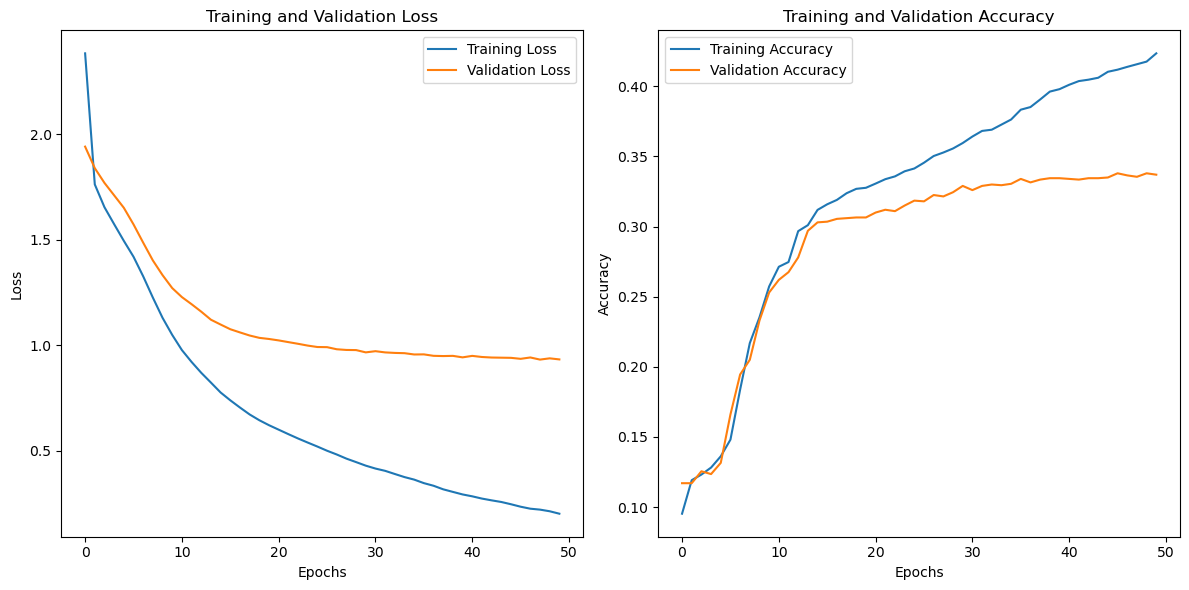

In [46]:
# Extracting the history data
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting the loss curves
plt.figure(figsize=(12, 6))

# Plotting Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [47]:
# Save the model
model.save('./Models/grammar_checker_model.h5')

### Evaluate the Model

In [48]:
# Evaluate the model on the validation data
validation_loss, validation_accuracy = model.evaluate([encoder_input_val, decoder_input_val], decoder_output_val)
print(f"Validation Loss: {validation_loss}")
print(f"Validation Accuracy: {validation_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3379 - loss: 0.9756
Validation Loss: 0.9337894320487976
Validation Accuracy: 0.3369999825954437


### Create Inference Models (for Prediction)

In [75]:
# Create encoder inference model
encoder_model = Model(encoder_inputs, encoder_states)

# Create decoder inference model
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_embedding_inf = Embedding(input_dim=len(output_tokenizer.word_index) + 1, output_dim=embedding_dim)
decoder_lstm_inf = LSTM(hidden_units, return_sequences=True, return_state=True)
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm_inf(decoder_embedding_inf(decoder_inputs), initial_state=decoder_states_inputs)
decoder_dense_inf = Dense(len(output_tokenizer.word_index) + 1, activation='softmax')
decoder_outputs_inf = decoder_dense_inf(decoder_outputs_inf)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs_inf] + [state_h_inf, state_c_inf])

### Test the Model with Grammatical Error Sentences

In [76]:
error_sentences = [
    "நான் நேற்று பாடம் படிக்கிறேன்.",
    "அவள் பாடம் படித்தான்."
]

correct_sentences = [
    "நான் நேற்று பாடம் படித்தேன்.",
    "அவள் பாடம் படித்தாள்."
]


In [99]:
# Define the function to decode the output sequence from the model
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = output_tokenizer.word_index['<start>']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = None
        for word, index in output_tokenizer.word_index.items():
            if index == sampled_token_index:
                sampled_word = word
                break
        if sampled_word == '<end>' or len(decoded_sentence.split()) > max_target_length:
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    return decoded_sentence.strip()


In [79]:
# Test model on both error and correct sentences
predictions_error = []
predictions_correct = []

# Preprocess and get predictions for error sentences
for input_sentence in error_sentences:
    # Ensure max_input_length is consistent with the sentence length
    max_input_length = max(max(len(input_sentence.split()) for sentence in error_sentences), 8)
    # Apply padding and truncation based on the updated max_input_length
    input_seq = pad_sequences(input_tokenizer.texts_to_sequences([input_sentence]), maxlen=max_input_length, padding='post', truncating='post')
    predicted_sentence = decode_sequence(input_seq)
    predictions_error.append(predicted_sentence)

# Preprocess and get predictions for correct sentences
for input_sentence in correct_sentences:
    input_seq = pad_sequences(input_tokenizer.texts_to_sequences([input_sentence]), maxlen=max_input_length, padding='post')
    predicted_sentence = decode_sequence(input_seq)
    predictions_correct.append(predicted_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step

c:\Users\Hp\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_5', 'keras_tensor_39', 'keras_tensor_40']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

In [80]:
predictions_correct

['கடைக்கு கடைக்கு கடைக்கு கடைக்கு கடைக்கு கடைக்கு கடைக்கு ஆராய்ச்சி ஆராய்ச்சி ஆராய்ச்சி ஆராய்ச்சி',
 'வந்து வந்து முயல்கிறான். முயல்கிறான். முயல்கிறான். நினைவுபடுத்துகிறீர்கள். நினைவுபடுத்துகிறீர்கள். நினைவுபடுத்துகிறீர்கள். நினைவுபடுத்துகிறீர்கள். ஆராய்ச்சி ஆராய்ச்சி']

### Evaluating BLEU Scores

In [81]:
from nltk.translate.bleu_score import sentence_bleu

# Reference sentences for error sentences
references_error = [
    ["நான் நேற்று பாடம் படித்தேன்."],  # Expected grammatical sentences
    ["அவள் பாடம் படித்தாள்."]
]

# Reference sentences for correct sentences
references_correct = [
    ["நான் நேற்று பாடம் படித்தேன்."],
    ["அவள் பாடம் படித்தாள்."]
]

# Calculate BLEU scores for the error sentences
bleu_scores_error = [sentence_bleu(ref, pred, weights=(0.5, 0.5)) for pred, ref in zip(predictions_error, references_error)]

# Calculate BLEU scores for the correct sentences
bleu_scores_correct = [sentence_bleu(ref, pred, weights=(0.5, 0.5)) for pred, ref in zip(predictions_correct, references_correct)]

# Compute average BLEU score for both sets
avg_bleu_score_error = sum(bleu_scores_error) / len(bleu_scores_error)
avg_bleu_score_correct = sum(bleu_scores_correct) / len(bleu_scores_correct)

# Display BLEU scores
print("BLEU Scores for Error Sentences:")
for i, score in enumerate(bleu_scores_error):
    print(f"Sentence {i+1} BLEU Score: {score:.4f}")
print(f"Average BLEU Score for Error Sentences: {avg_bleu_score_error:.4f}")

print("\nBLEU Scores for Correct Sentences:")
for i, score in enumerate(bleu_scores_correct):
    print(f"Sentence {i+1} BLEU Score: {score:.4f}")
print(f"Average BLEU Score for Correct Sentences: {avg_bleu_score_correct:.4f}")

BLEU Scores for Error Sentences:
Sentence 1 BLEU Score: 0.0380
Sentence 2 BLEU Score: 0.0713
Average BLEU Score for Error Sentences: 0.0547

BLEU Scores for Correct Sentences:
Sentence 1 BLEU Score: 0.0396
Sentence 2 BLEU Score: 0.0662
Average BLEU Score for Correct Sentences: 0.0529


In [89]:
input_sentence = "அவள் பாடல்கள் பாடுகிறான்."
input_sequence = input_tokenizer.texts_to_sequences([input_sentence])
input_sequence

[[5, 21, 13]]

In [90]:
# Tokenizing the input paragraph
input_seq = pad_sequences(input_sequence, maxlen=max_input_length, padding='post')
input_seq

array([[ 5, 21, 13,  0,  0,  0,  0,  0]])

In [100]:
# Get the prediction
corrected_paragraph = decode_sequence(input_seq)

# Step 5: Display the results
print("Input Paragraph (with errors):")
print(input_sentence)

print("\nCorrected Paragraph (Predicted by the model):")
print(corrected_paragraph)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Input Paragraph (with errors):
அவள் பாடல்கள் பாடுகிறான்.

Corrected Paragraph (Predicted by the model):
ஆராய்ச்சி ஆராய்ச்சி ஆராய்ச்சி ஆராய்ச்சி ஆராய்ச்சி ஆராய்ச்சி மணலை மணலை மணலை மணலை மணலை


In [87]:
input_seq.shape

(1, 8)